In [ ]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
import torch
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_validate


%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (7, 5)

# Data reading

In [2]:
data_path = 'z_ML datasets__/'

FreeSolve_df = pd.read_csv(data_path + 'SAMPL.csv')

FreeSolve_df.head(1)

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625


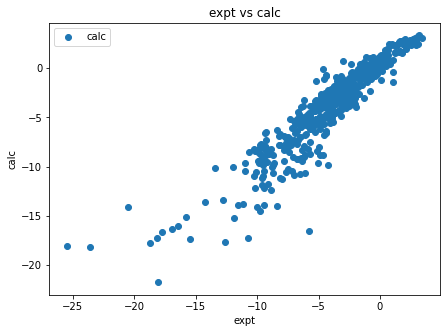

In [3]:
# plot below is taken from dataset creator article; it reflects general form of dependence between predicted value and calculated

FreeSolve_df.plot(x='expt', y='calc', style='o')  

plt.title('expt vs calc')  

plt.xlabel('expt');  plt.ylabel('calc');

plt.show()

# Data processing

,iupac,smiles,expt,calc,ROMol,n_Atoms,Molec_weight,LogP,AP,HA,MaxCharge_abs,MaxCharge
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625,,13,179.219,1.397,1,0.076923,0.496768,0.252836

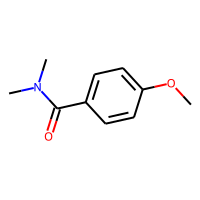

In [4]:
# before saving the file you should drop ROMol column "FreeSolve_df = FreeSolve_df.drop(['%name'], axis=1)"

seed = 4

PandasTools.AddMoleculeColumnToFrame(FreeSolve_df, smilesCol='smiles')

FreeSolve_df['n_Atoms'] = FreeSolve_df['ROMol'].map(lambda x: x.GetNumAtoms())
 
FreeSolve_df['Molec_weight'] = [Descriptors.MolWt(mol) for mol in FreeSolve_df['ROMol']]

FreeSolve_df['LogP'] = [Chem.Crippen.MolLogP(mol) for mol in FreeSolve_df['ROMol']]

FreeSolve_df['AP'] = [Chem.rdMolDescriptors.CalcNumAromaticRings(mol) for mol in FreeSolve_df['ROMol']]

FreeSolve_df['HA'] = [Chem.rdMolDescriptors.CalcNumAromaticRings(mol) / mol.GetNumHeavyAtoms() for mol in FreeSolve_df['ROMol']]

FreeSolve_df['MaxCharge_abs'] = [Descriptors.MaxAbsPartialCharge(mol) for mol in FreeSolve_df['ROMol']]

FreeSolve_df['MaxCharge'] = [Descriptors.MaxPartialCharge(mol) for mol in FreeSolve_df['ROMol']]

#FreeSolve_df = FreeSolve_df.drop(['FP_1'], axis=1)

FreeSolve_df.head(1)

In [5]:
train_df = FreeSolve_df.sample(frac=.8, random_state = seed)
test_df = FreeSolve_df[~FreeSolve_df.index.isin(train_df.index)]

print('Train set shape:', train_df.shape, '\n', 'Test set shape:', test_df.shape)

Train set shape: (514, 12) 
 Test set shape: (128, 12)


In [6]:
target = 'calc'

dim = 7

signs = ['n_Atoms','MaxCharge_abs', 'MaxCharge', 'LogP', 'Molec_weight', 'HA', 'AP']

# train samples processing
train_y = np.asanyarray(train_df[[target]]).astype(np.float32)
train_x = np.asanyarray(train_df[[signs[0],signs[1],signs[2],signs[3],signs[4],signs[5],signs[6]]]).astype(np.float32)

train_x = torch.from_numpy(train_x.reshape(train_x.shape[0], dim))
train_y = torch.from_numpy(train_y.reshape(train_y.shape[0], 1))

# tesr samples processing
test_y = np.asanyarray(test_df[[target]]).astype(np.float32)
test_x = np.asanyarray(test_df[[signs[0],signs[1],signs[2],signs[3],signs[4],signs[5],signs[6]]]).astype(np.float32)

test_x = torch.from_numpy(test_x.reshape(test_x.shape[0], dim))
test_y = torch.from_numpy(test_y.reshape(test_y.shape[0], 1))

# Random forest

In [7]:
def random_forest(train_x, train_y, seed, n_estimators):

    RF_Reg = RandomForestRegressor(random_state=seed, n_estimators = n_estimators)

    RF_Reg.fit(train_x, train_y.numpy().ravel())
   
    return RF_Reg

In [8]:
res = []

for i in range(1, 100):
    
    if not i % (100//25):
        
        RF_Reg = random_forest(train_x, train_y, seed, i)
        
        RF_Reg = RF_Reg.predict(test_x)

        RMSE_RF = sklearn.metrics.mean_squared_error(test_y.detach().numpy(), RF_Reg) 

        RMSE_RF = round(np.sqrt(RMSE_RF), 4)
        
        res_dict = {'n_estimators': i, 'RMSE': RMSE_RF}

        res.append(res_dict)
        
res = pd.DataFrame(res)

In [9]:
res.sort_values(by='RMSE').head(3)

,n_estimators,RMSE
10,44,1.7951
12,52,1.7983
11,48,1.8039


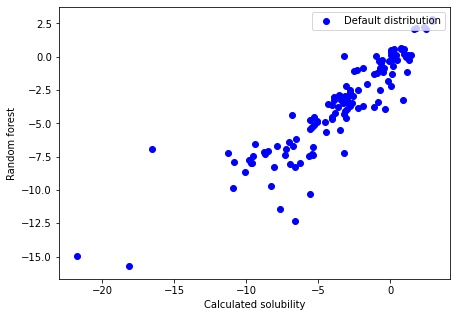

In [10]:
plt.plot(test_y.numpy(), RF_Reg, 'o', c = 'b', label = 'Default distribution')
    
plt.ylabel('Random forest');  
plt.xlabel('Calculated solubility');
    
plt.legend(loc = 'upper right');

# Gradient Boosting Regression

In [16]:
def Grad_boost(train_x, train_y, seed, n_estimators):

    GB_Reg = GradientBoostingRegressor(random_state=seed, n_estimators=n_estimators)

    GB_Reg.fit(train_x, train_y.numpy().ravel())
 
    return GB_Reg

In [18]:
res = []

for i in range(1, 100):
    
    if not i % (100//25):
        
        GB_Reg = Grad_boost(train_x, train_y, seed, i)
        
        GB_Reg = GB_Reg.predict(test_x)

        RMSE_GB = sklearn.metrics.mean_squared_error(test_y.detach().numpy(), GB_Reg) 

        RMSE_GB = round(np.sqrt(RMSE_GB), 4)
        
        res_dict = {'n_estimators': i, 'RMSE': RMSE_GB}

        res.append(res_dict)
        
res = pd.DataFrame(res)

In [19]:
res.sort_values(by='RMSE').head(3)

,n_estimators,RMSE
23,96,1.8353
22,92,1.8495
21,88,1.8604


# Bagging Regressor

In [7]:
def kono_itaria_no_kaban(train_x, train_y, seed, n_estimators):

    Bag_Reg = BaggingRegressor(random_state=seed, n_estimators = n_estimators) #(n_estimators=100, max_samples=15, random_state=seed, warm_start=True)

    Bag_Reg.fit(train_x, train_y.numpy().ravel())
   
    return Bag_Reg

In [8]:
res = []

for i in range(1, 100):
    
    if not i % (100//25):
        
        Bag_Reg = kono_itaria_no_kaban(train_x, train_y, seed, i)
        
        Bag_Reg = Bag_Reg.predict(test_x)

        RMSE_kaban = sklearn.metrics.mean_squared_error(test_y.detach().numpy(), Bag_Reg) 

        RMSE_kaban = round(np.sqrt(RMSE_kaban), 4)
        
        res_dict = {'n_estimators': i, 'RMSE': RMSE_kaban}

        res.append(res_dict)
        
res = pd.DataFrame(res)

In [9]:
res.sort_values(by='RMSE').head(3)

,n_estimators,RMSE
12,52,1.8395
18,76,1.8452
10,44,1.8496


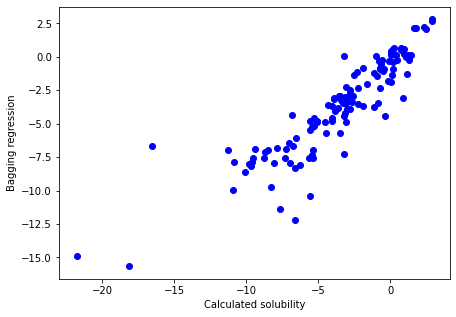

In [11]:
plt.plot(test_y.numpy(), Bag_Reg, 'o', c = 'b')  

plt.ylabel('Bagging regression');  
plt.xlabel('Calculated solubility');
    
#plt.legend(loc = 'upper right')